<a href="https://colab.research.google.com/github/hchang18/computer-vision/blob/main/harris_corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**EE510 Computer Vision**

**Homework 2**

Haeyoon Chang


**Implementation of Harris "Corners" Detection**

**Convert color image to grayscale**

Show the image in color and grayscale

In [ ]:
# import libraries 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
%matplotlib inline

# mount the google drive to get my image
from google.colab import drive
drive.mount('/content/gdrive')

# function to load the image 
def load_img():
    img = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/myhouse.jpg').astype(np.float32) / 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_img_gray():
    img = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/myhouse.jpg').astype(np.float32) /255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


# function to display an image
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img)

# function to display two images side by side
# first image (color), second image (grayscale) 
def display_side(img1, img2):
    fig = plt.figure(figsize=(12, 10))
    ax=fig.add_subplot(121)
    ax.imshow(img1)
    ax=fig.add_subplot(122)
    ax.imshow(img2, cmap='gray')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


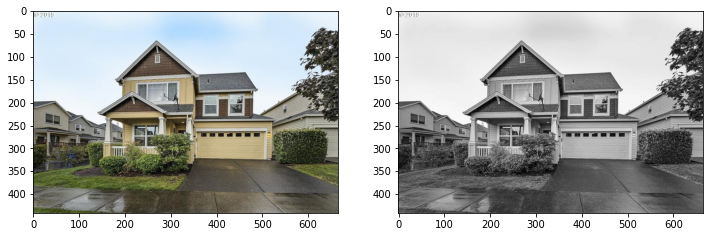

In [ ]:
# show the image in color and grayscale
color_img = load_img()
gray_img_orig = load_img_gray()
display_side(color_img, gray_img_orig)

**Calculate spatial derivatives** 


- Show the gradient components of the partial derivative in the horizontal
and vertical directions. 
    - Please see below
- Explain and justify how you calculated the derivative.
Note that there are many ways to estimate the derivative of an image. 

    - I choose to use Sobel operator to calculate partial derivative in horizontal and vertical directions to emphasize the impact of directly adjacent pixels. Applying the ```kernel_x``` and ```kernel_y``` filters gave me the same results as using ```cv2.Sobel()``` library.  

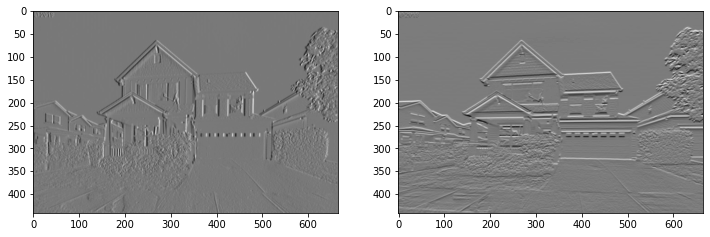

In [ ]:
# Gaussian smoothe the gray image
gray_img = cv2.GaussianBlur(gray_img_orig, (3,3), 0, 0)
# gray_img = cv2.medianBlur(gray_img, 5)

# convolution operator to apply on the entire image matrix
kernel_x = np.array([[-1,0,1],[-2,0,2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])

# calculate the grad with respect to horizontal and vertical
G_x = cv2.filter2D(gray_img,-1,kernel_x)
G_y = cv2.filter2D(gray_img,-1,kernel_y)

# same as below: 
# G_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
# G_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)

# show directional derivative
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(G_x, cmap='gray')
ax2.imshow(G_y, cmap='gray')


**Calculate structure tensor, M** 

- Show the images of the components of the matrix used for Harris corner detection. This includes the two diagonal elements and the off diagonal element. 
    - Please see below

Text(0.5, 1.0, 'B')

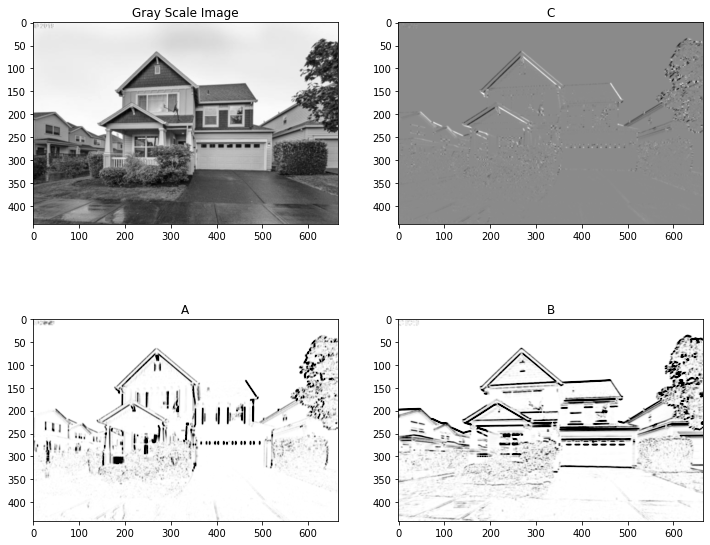

In [ ]:
# subtract the mean from image gradient 
# data is centered and 'DC' offset is removed 
# G_x = G_x - np.ones((G_x.shape[0], G_x.shape[1]))* G_x.mean()
# G_y = G_y - np.ones((G_y.shape[0], G_y.shape[1]))* G_y.mean()

# gradient covariance matrix using element-wise multiplication of G_x and G_y 
# let's assume that w = 1
A = np.multiply(G_x, G_x)
C = np.multiply(G_x, G_y)
B = np.multiply(G_y, G_y)

A = cv2.GaussianBlur(A, (3,3),0)
B = cv2.GaussianBlur(B, (3,3),0)
C = cv2.GaussianBlur(C, (3,3),0)

# images of the components of the matrix used for Harris detection 
# code reference: Prof. James McNames' jupyter notebook code
figure = plt.figure()
figure.set_size_inches(12, 10)
figure.clf()

ax = figure.add_subplot(221)
ax.imshow(gray_img, cmap='gray')
ax.set_title('Gray Scale Image')

ax = figure.add_subplot(222)
ax.imshow(C, cmap='gray', vmin=0.9*C.min(), vmax=0.9*C.max())
ax.set_title('C')

ax = figure.add_subplot(223)
ax.imshow(A, cmap='gray_r', vmin=0, vmax=1)
ax.set_title('A')

ax = figure.add_subplot(224)
ax.imshow(B, cmap='gray_r', vmin=0, vmax=1)
ax.set_title('B')

# print(A.min(), A.max())
# print(B.min(), B.max())
# print(C.min(), C.max())


**Calculate the response of the detector at each pixel** 

- Calculate the figure of merit used by Harris and plot this as an image.
    - Please see below
- Select a threshold for the figure of merit. Show the points that are above the threshold on the grayscale version of the original image. 
    - ```harris``` below is the result from response function. Threshold is set at the 97% quantile of the values in image pixels. Under 97 percentile threshold, the algorithm detected 8798 features
    - Threshold at 95-percentile resulted in 14664 features, and they seem to cluster around corners. I think it was detecting too many points in small region (overkill)
    - Threshold at 99-percent resulted in detecting 2933 features, and it was missing some of the points or patches (small cluster of pixels) that were obviously corners to human eyes   

The number of features selected:  8798 



Text(0.5, 1.0, 'Harris Feature')

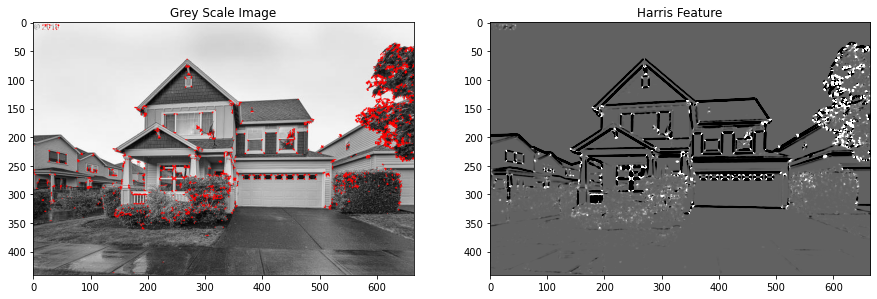

In [ ]:
# code reference: Prof. James McNames' jupyter notebook code

# calculate the response of the detector at each pixel
trace = A + B
det = A*B - C**2

k = 0.06

harris = det - k*np.square(trace)
harris = harris - np.percentile(harris,5)
harris = harris/np.percentile(harris, 99)

# print(harris.max())
# print(harris.min())

# threshold at 97% percentile
threshold = np.percentile(harris, 97)
harrisThresholded = harris>threshold

count_harris = np.count_nonzero(harrisThresholded)
print("The number of features selected: ", count_harris, '\n')

# Mark it on the color image 
img_marked = color_img.copy()
img_marked[harris > threshold] = [255,0,0]

# convert the image from Gray to RGB
# to mark the corners
arrayGray = np.array(gray_img_orig*255).astype('uint16')
img_marked_gray = cv2.cvtColor(arrayGray, cv2.COLOR_GRAY2RGB)
img_marked_gray[harris>threshold] = [255, 0, 0]

fig = plt.figure()
fig.set_size_inches(15,18)
fig.clf()

ax = fig.add_subplot(121)
ax.imshow(img_marked_gray)
# ax.imshow(img_marked) # use this to plot in the color image
ax.set_title('Grey Scale Image')

ax = fig.add_subplot(122)
ax.imshow(harris, cmap='gray', vmin=0, vmax=1)
ax.set_title('Harris Feature')

**Different figure of merit used by Harris** 

- Try a variation of the Harris corner detector with a different 
figure of merit, such as one of those in the book. Select a 
threshold that selects the same number of features as the 
original Harris detector. Show the points that are above the 
threshold on the grayscale version of the original
image. How does this variation compare? 

    - I tried good features to track (Shi and Tomasi 1994) which looks for pixels with the minimum eigen value above the threshold. The threshold which detects the same number of features as in Harris were 0.49, is 97 percentile, same as above. I do see almost no difference between Harris corner detection and Shi-Tomasi features when ```k = 0.06```, as suggested in the textbook. However, when I moved around ```k``` value, variation between two methods gets larger. 


The number of features selected:  8798 



Text(0.5, 1.0, 'Shi-Tomasi Good Features to Track')

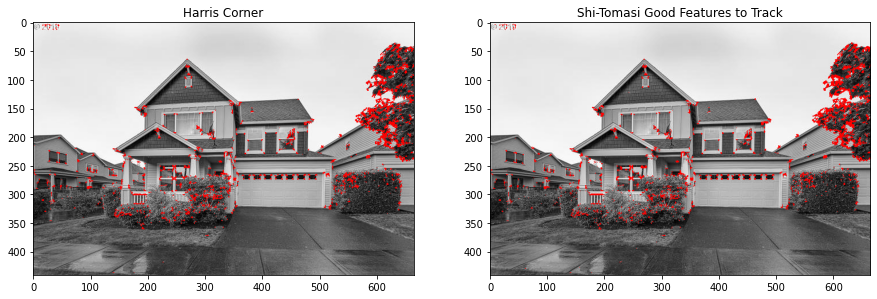

In [ ]:
# calculate eigen value of each pixel 
nRows = A.shape[0]
nCols = A.shape[1]
shi_tomasi = np.zeros_like(A)

for i in range(nRows):
    for j in range(nCols):
        a = A[i][j]
        b = B[i][j]
        c = C[i][j]
        eigen_vals = LA.eigvals([[a, c],[c, b]])
        shi_tomasi[i][j] = min(eigen_vals[0], eigen_vals[1])

shi_tomasi = shi_tomasi - np.percentile(shi_tomasi, 5)
shi_tomasi = shi_tomasi / np.percentile(shi_tomasi, 99)

# print(shi_tomasi.max())
# print(shi_tomasi.min())

q = 100 - count_harris/(shi_tomasi.shape[0]*shi_tomasi.shape[1])*100
threshold = np.percentile(shi_tomasi, q)
shi_tomasi_threshold = shi_tomasi > threshold

count_shi_tomasi = np.count_nonzero(shi_tomasi_threshold)
print("The number of features selected: ", count_shi_tomasi, '\n')

# convert the image from Gray to RGB
# to mark the corners
arrayGray = np.array(gray_img_orig*255).astype('uint16')
img_marked_gray_st = cv2.cvtColor(arrayGray, cv2.COLOR_GRAY2RGB)
img_marked_gray_st[shi_tomasi > threshold] = [255, 0, 0]

# plot Harris Corner and Shi-Tomasi features together
fig = plt.figure()
fig.set_size_inches(15,18)
fig.clf()

ax = fig.add_subplot(121)
ax.imshow(img_marked_gray)
# ax.imshow(img_marked) # use this to plot in the color image
ax.set_title('Harris Corner')

ax = fig.add_subplot(122)
ax.imshow(img_marked_gray_st)
ax.set_title('Shi-Tomasi Good Features to Track')